In [1]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from dataclasses import dataclass
from random import randint, random, choice
from typing import List
from math import exp, sqrt

In [2]:
UPPER_VAL = 1000
LOWER_VAL = -1000
UPPER_PARAM = 100
LOWER_PARAM = -100

Target Function:
f(x)= 58x^3 + -2x^2 + 94x + -92


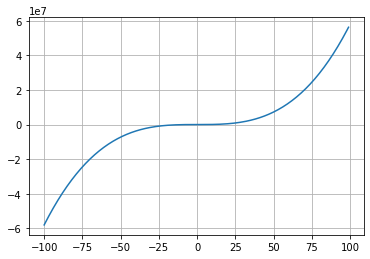

In [3]:
def f(x: float, a: int, b: int, c: int, d: int):
    return (a * x**3) + (b * x**2) + (c * x) + d

coefs = {
    "a": randint(LOWER_PARAM, UPPER_PARAM),
    "b": randint(LOWER_PARAM, UPPER_PARAM),
    "c": randint(LOWER_PARAM, UPPER_PARAM),
    "d": randint(LOWER_PARAM, UPPER_PARAM),
    
}

def print_target_function(coefs: dict=coefs):
    print(f'Target Function:\nf(x)= {coefs["a"]}x^3 + {coefs["b"]}x^2 + {coefs["c"]}x + {coefs["d"]}')

print_target_function()
target = partial(f, **coefs)

X = np.arange(-100, 100, 1)
Y = target(X)
plt.grid()
plt.plot(X,Y)

In [4]:
def mse(target: callable, candidate: callable):
    X = np.linspace(LOWER_VAL, UPPER_VAL, 100)
    y_target = target(X)
    y_candidate = candidate(X)
    errors = (y_target - y_candidate)**2
    return np.mean(errors)

def rmse(target: callable, candidate: callable):
    X = np.linspace(LOWER_VAL, UPPER_VAL, 100)
    y_target = target(X)
    y_candidate = candidate(X)
    errors = np.sqrt((y_target - y_candidate)**2)
    return np.mean(errors)

def fitness(target: callable, candidate: callable):
    return -rmse(target=target, candidate=candidate)

In [27]:
@dataclass 
class Solution:
    a: int
    b: int
    c: int
    d: int
    
    def as_function(self):
        return partial(f, a=self.a, b=self.b, c=self.c, d=self.d)
    
    def pprint(self):
        print(f'f(x)= {self.a}x^3 + {self.b}x^2 + {self.c}x + {self.d}')
    

def get_random_solution() -> Solution:
    return Solution(
        randint(LOWER_PARAM, UPPER_PARAM),
        randint(LOWER_PARAM, UPPER_PARAM),
        randint(LOWER_PARAM, UPPER_PARAM),
        randint(LOWER_PARAM, UPPER_PARAM)
    )

def get_neighborhood_solutions(solution: Solution) -> List[Solution]:
    neighborhood = []
    for val in (-2, -1, 1, 2):
        if LOWER_PARAM < solution.a < UPPER_PARAM:
            neighborhood.append(
                Solution(solution.a + val, solution.b, solution.c, solution.d)
            )
        if LOWER_PARAM < solution.b < UPPER_PARAM:
            neighborhood.append(
                Solution(solution.a, solution.b + val, solution.c, solution.d)
            )
        if LOWER_PARAM < solution.c < UPPER_PARAM:
            neighborhood.append(
                Solution(solution.a, solution.b, solution.c + val, solution.d)
            )
        if LOWER_PARAM < solution.d < UPPER_PARAM:
            neighborhood.append(
                Solution(solution.a, solution.b, solution.c, solution.d + val)
            )
    return neighborhood

def hamming_distance(sol1: Solution, sol2: Solution) -> int:
    return abs(sol1.a - sol2.a) + abs(sol1.b - sol2.b) + abs(sol1.c - sol2.c) + abs(sol1.d - sol2.d)  
    

In [29]:
def test_solution_class():
    
    test_sol = get_random_solution()
    
    for param in (test_sol.a, test_sol.b, test_sol.c, test_sol.d):    
        assert LOWER_PARAM <= param <= UPPER_PARAM

    test_neighborhood = get_neighborhood_solutions(test_sol)
    assert len(test_neighborhood) <= 16

    for neighbor in test_neighborhood:
        assert(hamming_distance(test_sol, neighbor)) <= 2
    return


for _ in range(10000):
    test_solution_class()


In [33]:
def local_search_best(target: callable, verbose=False):
    
    cur_sol = get_random_solution()
    cur_fit = fitness(target, cur_sol.as_function())
    
    fitness_evals = 0
        
    while True:
                
        if verbose:
            print(f"Current best {cur_sol}, Fitness = {cur_fit:.4f}")
        
        neighborhood = get_neighborhood_solutions(cur_sol)
        if len(neighborhood) == 0:
            break
            
        neighborhood.sort(key=lambda x: fitness(target, x.as_function()), reverse=True)
        
        fitness_evals += len(neighborhood)
        
        best_fit = fitness(target, neighborhood[0].as_function())
        
        if best_fit >= cur_fit:
            cur_sol = neighborhood[0]
            cur_fit = best_fit
            continue
        
        else:
            print(f"Finished Local Search Best\n-----")
            print(f"Fitness = {cur_fit:.4f}")
            print(f"Total Number of Fitness evaluations: {fitness_evals}")
            cur_sol.pprint()
            return


local_search_best(target)
print_target_function()
    

Finished Local Search Best
-----
Fitness = -0.0000
Total Number of Fitness evaluations: 3520
f(x)= 58x^3 + -2x^2 + 94x + -92
Target Function:
f(x)= 58x^3 + -2x^2 + 94x + -92


In [51]:
def local_search_first(target: callable, verbose=False):
    
    cur_sol = get_random_solution()
    cur_fit = fitness(target, cur_sol.as_function())
    
    fitness_evals = 0
    improved = True
        
    while improved:
                
        if verbose:
            print(f"Current best {cur_sol}, Fitness = {cur_fit:.4f}")
        
        neighborhood = get_neighborhood_solutions(cur_sol)
        if len(neighborhood) == 0:
            break
        
        for neighbor in neighborhood:
            
            improved = False
            fit = fitness(target, neighbor.as_function())
            fitness_evals += 1
            
            if fit >= cur_fit:
                cur_sol = neighbor
                cur_fit = fit
                improved = True
                break
            
        
    print(f"Finished Local Search First\n-----")
    print(f"Fitness = {cur_fit:.4f}")
    print(f"Total Number of Fitness evaluations: {fitness_evals}")
    cur_sol.pprint()
    return


local_search_first(target)
print_target_function()

KeyboardInterrupt: 

In [82]:
def SA(target: callable, T0:int=1000000, TN:int=1, verbose=False):
    
    T = T0
    
    cur_sol = get_random_solution()
    cur_fit = fitness(target, cur_sol.as_function())
    
    fitness_evals = 0
    
    def cooling(T: float, alpha: float) -> float:
        return alpha * T
    
    
    while T > TN:
        
        T = cooling(T, 0.995)
        
        if verbose:
            print(f"Temperature: {T}\nCurrent best {cur_sol}, Fitness = {cur_fit:.4f}")
        
        neighborhood = get_neighborhood_solutions(cur_sol)
        
        if len(neighborhood) == 0:
            break
            
        neighbor = choice(neighborhood)
            
        temp_fit = fitness(target, neighbor.as_function())
        fitness_evals += 1

        if temp_fit >= cur_fit:
            cur_sol = neighbor
            cur_fit = temp_fit
            continue

        else:
            
            fit_distance = abs(cur_fit - temp_fit)
            p_accept = exp(-(fit_distance / T))
            
            if verbose:
                print(f"Acceptance P: {p_accept}")

            if random() < p_accept:
                cur_sol = neighbor
                cur_fit = temp_fit

    print(f"Finished Simulated Annealing\n-----")
    print(f"Fitness = {cur_fit:.4f}")
    print(f"Total Number of Fitness evaluations: {fitness_evals}")
    cur_sol.pprint()
    return
        

SA(target, verbose=False)
print_target_function()

Finished Simulated Annealing
-----
Fitness = -1.0000
Total Number of Fitness evaluations: 2757
f(x)= 58x^3 + -2x^2 + 94x + -93
Target Function:
f(x)= 58x^3 + -2x^2 + 94x + -92
